In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import time

In [2]:
# Medical Insurance Cost dataset from https://www.kaggle.com/mirichoi0218/insurance
insurance = pd.read_csv('~/Desktop/Data_Science/insurance.csv')

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
insurance.shape

(1338, 7)

### Age

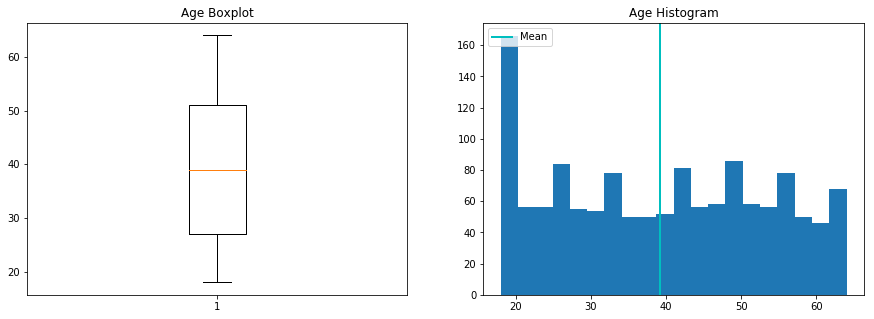

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['age'].dropna(how = 'any'))
plt.title('Age Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['age'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['age'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Age Histogram')

plt.show()

Ages range from 18 to 64 - adults before medicare age.  The average age is 39, which is below the mid-point of the age range, mostly due the greatest number of records for those under age 20.

### Sex/Gender

(array([0, 1]), <a list of 2 Text xticklabel objects>)

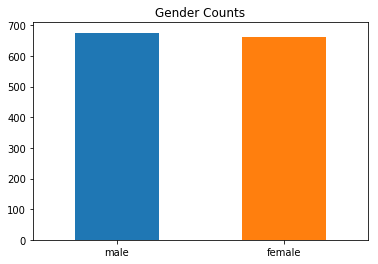

In [7]:
plt.title('Gender Counts')
pd.value_counts(insurance['sex']).plot.bar()
plt.xticks(rotation = 0)

Equal number of male and female records

In [8]:
#Convert to numeric
insurance['male_gender'] = 0
insurance.loc[insurance['sex'] == 'male', 'male_gender'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('sex', 1)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

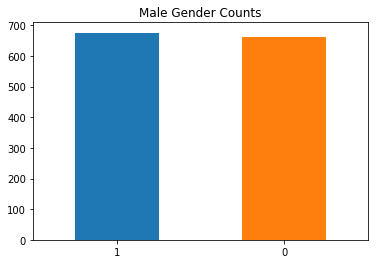

In [9]:
plt.title('Male Gender Counts')
pd.value_counts(insurance['male_gender']).plot.bar()
plt.xticks(rotation = 0)

### BMI

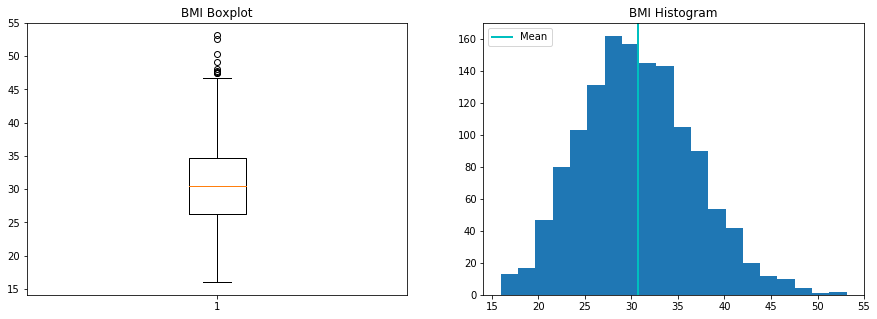

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['bmi'].dropna(how = 'any'))
plt.title('BMI Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['bmi'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['bmi'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('BMI Histogram')

plt.show()

Normal distribution of values, with a median of 31.7

According to Wikipedia, the body mass index (BMI) is a value derived from the weight and height of an individual. Commonly accepted BMI ranges are underweight: under 18.5 kg/m2, normal weight: 18.5 to 25, overweight: 25 to 30, obese: over 30.  This means that most of these records are for individuals considered to have an unhealthy weight for their height.

### Children

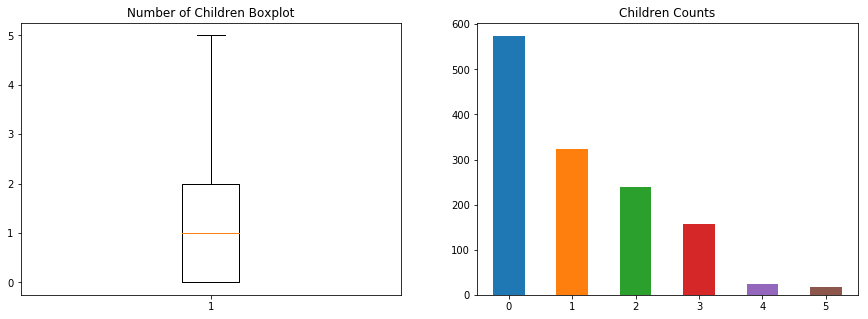

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['children'].dropna(how = 'any'))
plt.title('Number of Children Boxplot')

plt.subplot(1, 2, 2)
plt.title('Children Counts')
pd.value_counts(insurance['children']).plot.bar()
plt.xticks(rotation = 0)

plt.show()

More records are for individuals with children than not, but the most frequent number of children is none.

### Smoker

no     1064
yes     274
dtype: int64


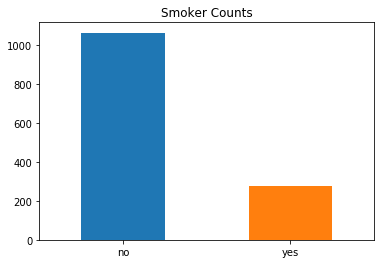

In [12]:
plt.title('Smoker Counts')
pd.value_counts(insurance['smoker']).plot.bar()
plt.xticks(rotation = 0)
print(pd.value_counts(insurance['smoker'].values, sort=False))

There are more non-smokers (1064) than smokers (274)

In [13]:
#Convert to numeric
insurance['smoke'] = 0
insurance.loc[insurance['smoker'] == 'yes', 'smoke'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('smoker', 1)

0    1064
1     274
dtype: int64


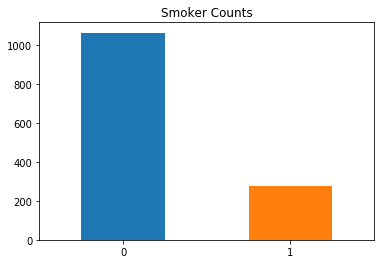

In [14]:
plt.title('Smoker Counts')
pd.value_counts(insurance['smoke']).plot.bar()
plt.xticks(rotation = 0)
print(pd.value_counts(insurance['smoke'].values, sort=False))

### Region

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

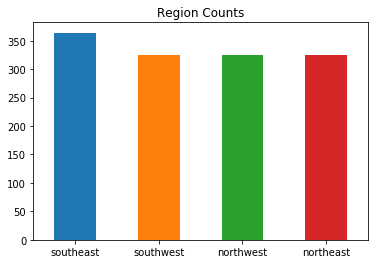

In [15]:
plt.title('Region Counts')
pd.value_counts(insurance['region']).plot.bar()
plt.xticks(rotation = 0)

There are an equal number of records from the Northwest, Northeast and Southwest, and slightly more records from the Southeast.

In [16]:
#Convert to numeric
insurance['south'] = 0
insurance.loc[insurance['region'].str.contains("south", na=False), 'south'] = 1
insurance['east'] = 0
insurance.loc[insurance['region'].str.contains("east", na=False), 'east'] = 1

#Delete original 'smoker' variable
insurance = insurance.drop('region', 1)

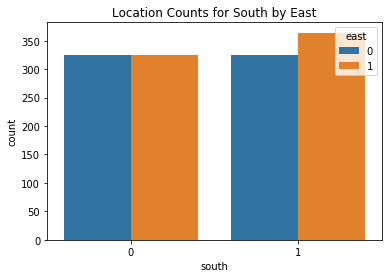

In [17]:
import seaborn as sns
plt.title('Location Counts for South by East')
sns.countplot(x='south', hue='east', data=insurance)

### Charges

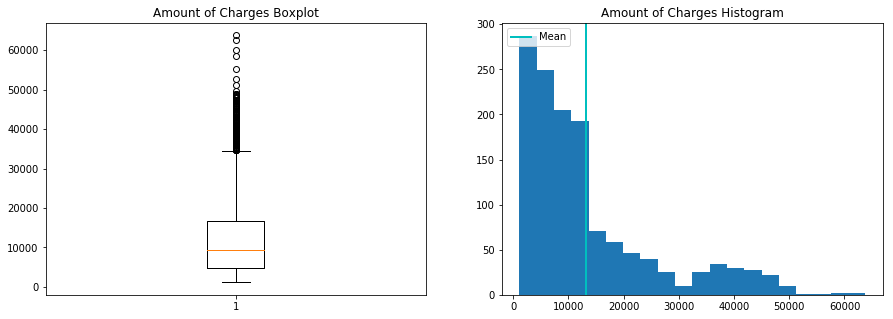

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['charges'].dropna(how = 'any'))
plt.title('Amount of Charges Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['charges'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['charges'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Amount of Charges Histogram')

plt.show()

Heavily left-skewed data with a mean of $13,270.  Outliers range up to $63,770.

Let's try a log of the Charges variable to get more normally distributed feature

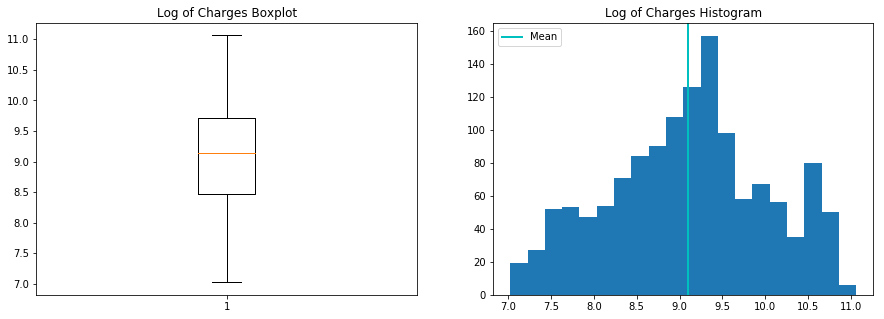

In [48]:
insurance['charges_log'] = np.log(insurance['charges'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(insurance['charges_log'].dropna(how = 'any'))
plt.title('Log of Charges Boxplot')

plt.subplot(1, 2, 2)
plt.hist(insurance['charges_log'].dropna(how = 'any'), bins=20)
plt.axvline(insurance['charges_log'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Log of Charges Histogram')

plt.show()

That looks like a more useful feature - no more outliers and the distribution is much closer to normal

### Recap Data

In [19]:
insurance.head()

,age,bmi,children,charges,male_gender,smoke,south,east
0,19,27.900,0,16884.92400,0,1,1,0
1,18,33.770,1,1725.55230,1,0,1,1
2,28,33.000,3,4449.46200,1,0,1,1
3,33,22.705,0,21984.47061,1,0,0,0
4,32,28.880,0,3866.85520,1,0,0,0


In [20]:
insurance.shape

(1338, 8)

## Use a Decision Tree to predict gender

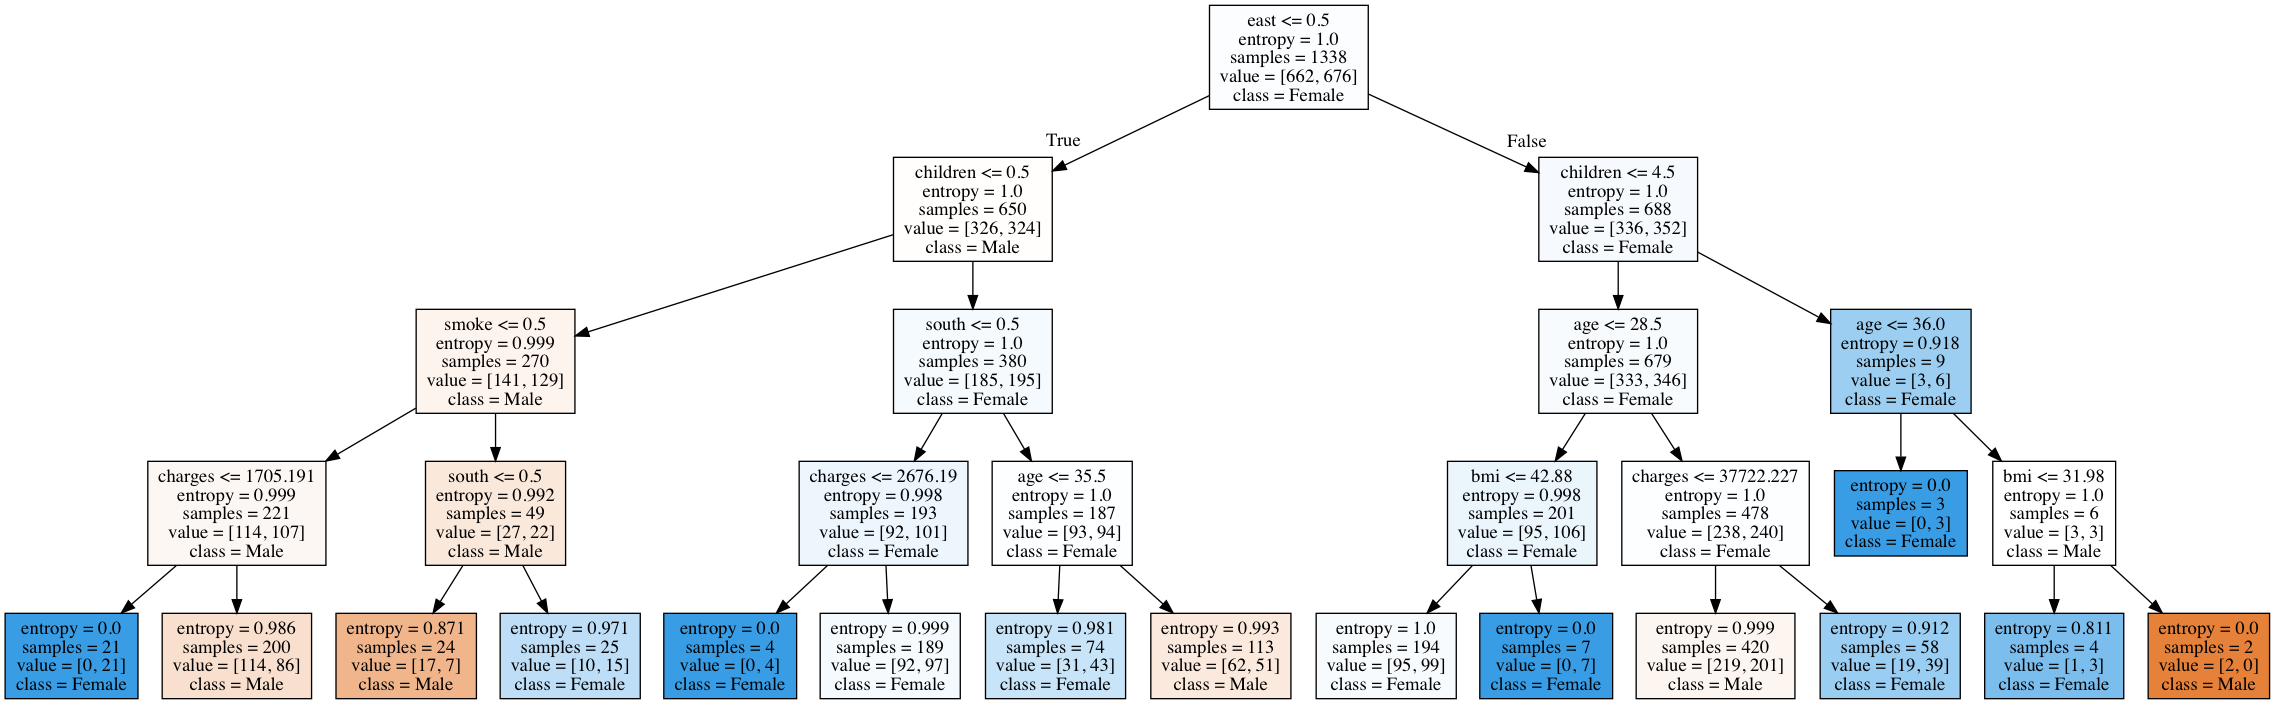

In [25]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)

X = insurance.drop('male_gender', 1)
Y = insurance['male_gender']

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Male', 'Female'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [24]:
score = cross_val_score(decision_tree, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation Average: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.53333333 0.53333333 0.5        0.50746269 0.47761194 0.46268657
 0.45864662 0.4962406  0.47368421 0.54135338]

Cross Validation Average: 0.50 (+/- 0.06)


In [29]:
#Test max_features

def tree_feature_fit(features):
    dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=features,
        max_depth=4,
        random_state = 1337
    )
    score = cross_val_score(dt, X, Y, cv=10)
    return print("%d Max Features has a Cross Validation mean of: %0.2f (+/- %0.2f)" % (features, score.mean(), score.std() * 2))
    
for i in range(7):
    tree_feature_fit(i + 1)

1 Max Features has a Cross Validation mean of: 0.50 (+/- 0.06)
2 Max Features has a Cross Validation mean of: 0.57 (+/- 0.09)
3 Max Features has a Cross Validation mean of: 0.56 (+/- 0.07)
4 Max Features has a Cross Validation mean of: 0.56 (+/- 0.08)
5 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)
6 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)
7 Max Features has a Cross Validation mean of: 0.56 (+/- 0.06)


In [30]:
#Test max_depth, use max_features=7 due to best result above

def tree_depth_fit(depth):
    dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=2,
        max_depth=depth,
        random_state = 1337
    )
    score = cross_val_score(dt, X, Y, cv=5)
    return print("Depth of %d has a Cross Validation mean of: %0.2f (+/- %0.2f)" % (depth, score.mean(), score.std() * 2))
    
for i in range(50):
    tree_depth_fit(i + 1)

Depth of 1 has a Cross Validation mean of: 0.53 (+/- 0.04)
Depth of 2 has a Cross Validation mean of: 0.54 (+/- 0.03)
Depth of 3 has a Cross Validation mean of: 0.56 (+/- 0.05)
Depth of 4 has a Cross Validation mean of: 0.57 (+/- 0.06)
Depth of 5 has a Cross Validation mean of: 0.55 (+/- 0.05)
Depth of 6 has a Cross Validation mean of: 0.55 (+/- 0.04)
Depth of 7 has a Cross Validation mean of: 0.54 (+/- 0.06)
Depth of 8 has a Cross Validation mean of: 0.54 (+/- 0.08)
Depth of 9 has a Cross Validation mean of: 0.55 (+/- 0.05)
Depth of 10 has a Cross Validation mean of: 0.56 (+/- 0.08)
Depth of 11 has a Cross Validation mean of: 0.54 (+/- 0.08)
Depth of 12 has a Cross Validation mean of: 0.55 (+/- 0.07)
Depth of 13 has a Cross Validation mean of: 0.55 (+/- 0.04)
Depth of 14 has a Cross Validation mean of: 0.57 (+/- 0.10)
Depth of 15 has a Cross Validation mean of: 0.56 (+/- 0.06)
Depth of 16 has a Cross Validation mean of: 0.56 (+/- 0.05)
Depth of 17 has a Cross Validation mean of: 0.57 

In [31]:
start_time = time.time()

dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=2,
        max_depth=24,
        random_state = 1337
    )
score = cross_val_score(dt, X, Y, cv=5)
print("Cross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation mean of: 0.60 (+/- 0.05)

--- 0.036448001861572266 seconds ---


In [32]:
# recursive feature elimination

from sklearn.feature_selection import RFE
selector = RFE(dt)
selector = selector.fit(X, Y)

rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,age,1
1,bmi,1
3,charges,1
2,children,2
5,south,3
6,east,4
4,smoke,5


In [38]:
# drop least significant feature and test accuracy

X = insurance[['age', 'bmi', 'charges', 'children', 'south', 'east']]

start_time = time.time()

score = cross_val_score(dt, X, Y, cv=5)
print("Cross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation mean of: 0.56 (+/- 0.04)

--- 0.03900909423828125 seconds ---


That impacted accuracy too much, so we need to keep all features

In [39]:
# retest with all features

X = insurance.drop('male_gender', 1)

start_time = time.time()

score = cross_val_score(dt, X, Y, cv=5)
print("Cross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation mean of: 0.60 (+/- 0.05)

--- 0.03686118125915527 seconds ---


## Use a Random Forest to predict gender

In [40]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
X = insurance.drop('male_gender', 1)
Y = insurance['male_gender']
#X = X.dropna(axis=1)

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation Average: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Validation Scores:
 [0.6        0.52592593 0.6119403  0.58208955 0.58955224 0.58955224
 0.59398496 0.57142857 0.57142857 0.60150376]

Cross Validation Average: 0.58 (+/- 0.05)


In [46]:
start_time = time.time()

rfc = ensemble.RandomForestClassifier()
X = insurance.drop('male_gender', 1)
Y = insurance['male_gender']
#X = X.dropna(axis=1)

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation Mean: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation Scores:
 [0.59259259 0.54814815 0.54477612 0.62686567 0.60447761 0.55970149
 0.55639098 0.57894737 0.58646617 0.55639098]

Cross Validation Mean: 0.58 (+/- 0.05)

--- 0.3265690803527832 seconds ---


Cross Validation by ten folds shows a mean accuracy of 0.58, but ranges from 0.545 to 0.627.<br>
Let's try recursive feature selection and see if we can improve our data.

In [42]:
# recursive feature elimination

selector = RFE(rfc)
selector = selector.fit(X, Y)

rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,age,1
1,bmi,1
3,charges,1
2,children,2
5,south,3
6,east,4
4,smoke,5


In [45]:
# drop least significant feature and test accuracy

X = insurance[['age', 'bmi', 'charges', 'children', 'south', 'east']]

start_time = time.time()

score = cross_val_score(rfc, X, Y, cv=10)
print("Cross Validation Scores:\n", score)
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


print("\n--- %s seconds ---" % (time.time() - start_time))

Cross Validation Scores:
 [0.58518519 0.51851852 0.51492537 0.55223881 0.53731343 0.52985075
 0.54887218 0.51879699 0.57894737 0.5037594 ]

Cross Validation mean of: 0.54 (+/- 0.05)

--- 0.3321201801300049 seconds ---
